# 학습 결과

user1의 scene 1~3만 사용해서 학습

scene보다 user가 많기 때문에 데이터의 양이 확연히 줄어듬에도 불구하고 성능이 괜찮음.  
적은 데이터 특화됐기 때문인지는 모르겠다.

나머지 scene에 대해서도 잘 학습을 하면서 user에 대해서도 특화된다면 성능을 상당히 끌어올릴 수 있을 것으로 기대됨.  
--> curriculum learning

In [1]:
from multiprocessing import cpu_count
from pathlib import Path
from typing import List, Union, AnyStr
from math import pi
import pickle

import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn import model_selection
from tqdm import tqdm
import torch_optimizer
from torch.utils.data import Dataset
import pandas as pd
import random

import torch_burn as tb
import utils

In [2]:
EXPERIMENT_NAME = '1122-Scene3-CLSTM2-win48'
CHECKPOINT_DIR = Path('checkpoint', EXPERIMENT_NAME)
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

DATA_DIR = Path('data/1116')
TRAIN_FILES = sorted(list(DATA_DIR.glob('*scene3_0.csv')))
TEST_FILES = sorted(list(DATA_DIR.glob('*scene3_1.csv')))

# 데이터셋 생성

scene1에 대해서 모든 user의 데이터를 하나로 합친다.

In [3]:
WINDOW_SIZE = 48

In [4]:
class CSVSequentialDataset(Dataset):
    def __init__(self, csvfile,
                 window_size=300, randomized_window_size=False,
                 stride=30, randomized_stride=False):
        super(CSVSequentialDataset, self).__init__()

        self.xcols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll',
                      'acceleration_x', 'acceleration_y', 'acceleration_z']
        self.ycols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll']

        self.csv = pd.read_csv(csvfile)
        self.window_size = window_size

        self.indexes = []
        i = 0
        while i <= len(self.csv) - window_size * 2:
            if randomized_window_size:
                self.indexes.append((i, i + random.randint(window_size // 2, window_size)))
            else:
                self.indexes.append((i, i + window_size))

            if randomized_stride:
                i += random.randint(1, stride)
            else:
                i += stride

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, idx):
        s, t = self.indexes[idx]
        x = self.csv.iloc[s:t][self.xcols].to_numpy()
        y = self.csv.iloc[t + 6][self.ycols].to_numpy()

        x = torch.tensor(x, dtype=torch.float32) # 300, 6
        y = torch.tensor(y, dtype=torch.float32) # 3
        
        #x[:, :3] *= pi / 180
        x[:, 3:] /= 10

        return x, y

In [5]:
ds_train = [CSVSequentialDataset(f,  
                                 window_size=WINDOW_SIZE, randomized_window_size=False,
                                 stride=5, randomized_stride=True) for f in TRAIN_FILES]
ds_train = tb.data.ChainDataset(*ds_train)
ds_test = [CSVSequentialDataset(f,  
                                window_size=WINDOW_SIZE, randomized_window_size=False,
                                stride=5, randomized_stride=True) for f in TEST_FILES]
ds_test = tb.data.ChainDataset(*ds_test)

In [6]:
len(ds_train), len(ds_test)

(18733, 18174)

In [7]:
ds_train[0][0].shape, ds_train[0][1].shape

(torch.Size([48, 6]), torch.Size([3]))

In [8]:
x, y = ds_train[0]

In [9]:
x.shape

torch.Size([48, 6])

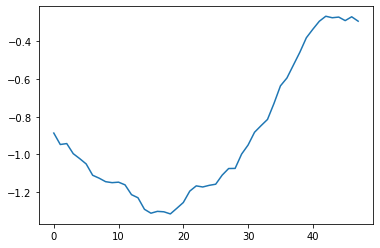

In [10]:
plt.plot(x[:, 2])

# 모델 생성

In [11]:
class CLSTM(nn.Module):
    def __init__(self, input_size=6, hidden_size=24, num_layers=8, dropout=0.0, bidirectional=False):
        super(CLSTM, self).__init__()

        self.conv_in = nn.Sequential(
            nn.Conv1d(input_size, 12, 5, padding=2),
            nn.BatchNorm1d(12),
            nn.LeakyReLU(),
            nn.Conv1d(12, 24, 5, padding=2),
            nn.BatchNorm1d(24),
        )

        self.rnn = nn.LSTM(input_size=24,
                           hidden_size=hidden_size,
                           num_layers=num_layers,
                           batch_first=True,
                           dropout=dropout,
                           bidirectional=bidirectional)

        out_channels = 2 * hidden_size if bidirectional else hidden_size
        self.fc = nn.Linear(out_channels, 3)

    def forward(self, x):
        x = x.transpose(1, 2)  # B, 48, 6 --> B, 6, 48
        x = self.conv_in(x)  # B, 64, 48
        x = x.transpose(1, 2)  # B, 48, 64

        outs, (hiddens, cells) = self.rnn(x)
        x = outs[:, -1, ...]
        x = self.fc(x)

        return x

In [12]:
model = CLSTM(input_size=6, hidden_size=64, num_layers=8, dropout=0.2, bidirectional=True).cuda()

In [13]:
criterion = nn.MSELoss().cuda()
optimizer = torch_optimizer.RAdam(model.parameters())

In [14]:
metrics = [tb.metrics.ModuleMetric(criterion, 'loss'),
           utils.HPMetric('hp_metric'),
           utils.HPSignalHistory(CHECKPOINT_DIR / 'sample' / '{epoch:04d}.npy', 'hp_signal')]

In [15]:
callbacks = [tb.callbacks.EarlyStopping(metrics[0]),
             tb.callbacks.LRDecaying(optimizer, metrics[0])]

In [16]:
trainer = tb.Trainer(model, optimizer, metrics, callbacks, ncols=100)

In [17]:
trainer.fit(ds_train, ds_test, num_epochs=100, batch_size=256, shuffle=True, pin_memory=True)

[0002/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :  19.049786
 - Pitch        :  10.015392
 - Roll         :   2.573593
 - RMS          :  12.514336
 - 99% Tile     :  43.654971
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0001.npy


[0003/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :  15.371325
 - Pitch        :   8.882199
 - Roll         :   2.454722
 - RMS          :  10.347250
 - 99% Tile     :  39.116020
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0002.npy


[0004/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :  12.459380
 - Pitch        :   8.178793
 - Roll         :   2.387285
 - RMS          :   8.714508
 - 99% Tile     :  34.047533
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0003.npy


[0005/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :  10.177804
 - Pitch        :   7.615049
 - Roll         :   2.389005
 - RMS          :   7.467351
 - 99% Tile     :  30.633722
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0004.npy


[0006/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   8.561134
 - Pitch        :   7.040679
 - Roll         :   2.337144
 - RMS          :   6.540297
 - 99% Tile     :  27.535712
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0005.npy


[0007/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   7.075264
 - Pitch        :   6.118047
 - Roll         :   2.396057
 - RMS          :   5.574674
 - 99% Tile     :  24.695565
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0006.npy


[0008/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   6.062052
 - Pitch        :   6.145328
 - Roll         :   2.373391
 - RMS          :   5.168705
 - 99% Tile     :  21.849632
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0007.npy


[0009/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   5.169653
 - Pitch        :   5.428637
 - Roll         :   2.373213
 - RMS          :   4.539734
 - 99% Tile     :  19.603342
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0008.npy


[0010/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   4.546235
 - Pitch        :   4.818482
 - Roll         :   2.364993
 - RMS          :   4.061166
 - 99% Tile     :  17.870408
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0009.npy


[0011/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.756395
 - Pitch        :   4.217803
 - Roll         :   2.354142
 - RMS          :   3.532815
 - 99% Tile     :  15.983514
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0010.npy


[0012/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.598769
 - Pitch        :   3.441067
 - Roll         :   2.329420
 - RMS          :   3.173761
 - 99% Tile     :  14.558749
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0011.npy


[0013/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.221772
 - Pitch        :   2.760350
 - Roll         :   2.340796
 - RMS          :   2.797539
 - 99% Tile     :  13.246846
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0012.npy


[0014/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.973737
 - Pitch        :   2.638866
 - Roll         :   2.324146
 - RMS          :   2.658845
 - 99% Tile     :  12.314615
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0013.npy


[0015/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.751110
 - Pitch        :   2.552493
 - Roll         :   2.344536
 - RMS          :   2.554778
 - 99% Tile     :  11.961668
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0014.npy


[0016/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.139204
 - Pitch        :   2.152275
 - Roll         :   2.341720
 - RMS          :   2.213002
 - 99% Tile     :  10.948181
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0015.npy


[0017/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.965853
 - Pitch        :   1.979398
 - Roll         :   2.352114
 - RMS          :   2.106738
 - 99% Tile     :  10.596626
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0016.npy


[0018/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.022609
 - Pitch        :   1.724883
 - Roll         :   2.368364
 - RMS          :   2.055506
 - 99% Tile     :   9.883525
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0017.npy


[0019/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.906967
 - Pitch        :   1.729969
 - Roll         :   2.327612
 - RMS          :   2.003921
 - 99% Tile     :   9.553852
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0018.npy


[0020/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.811414
 - Pitch        :   1.480216
 - Roll         :   2.268616
 - RMS          :   1.881389
 - 99% Tile     :   8.976240
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0019.npy


[0021/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.675850
 - Pitch        :   1.616725
 - Roll         :   2.270386
 - RMS          :   1.877670
 - 99% Tile     :   8.981629
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0020.npy


[0022/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.418661
 - Pitch        :   1.520969
 - Roll         :   2.305356
 - RMS          :   1.792634
 - 99% Tile     :   8.715536
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0021.npy


[0023/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   2.141084
 - Pitch        :   1.528387
 - Roll         :   2.299877
 - RMS          :   2.017394
 - 99% Tile     :   8.338487
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0022.npy


[0024/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.314003
 - Pitch        :   1.366001
 - Roll         :   2.275283
 - RMS          :   1.709724
 - 99% Tile     :   8.089202
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0023.npy


[0025/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.995525
 - Pitch        :   1.364174
 - Roll         :   2.197813
 - RMS          :   1.886220
 - 99% Tile     :   7.902469
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0024.npy


[0026/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.544243
 - Pitch        :   1.214823
 - Roll         :   2.286103
 - RMS          :   1.740378
 - 99% Tile     :   7.675876
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0025.npy


[0027/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   2.581546
 - Pitch        :   1.312463
 - Roll         :   2.264487
 - RMS          :   2.122486
 - 99% Tile     :   7.872049
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0026.npy


[0028/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.383517
 - Pitch        :   1.240396
 - Roll         :   2.249099
 - RMS          :   1.684354
 - 99% Tile     :   7.559221
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0027.npy


[0029/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   2.852860
 - Pitch        :   1.333560
 - Roll         :   2.211801
 - RMS          :   2.221806
 - 99% Tile     :   7.607039
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0028.npy


[0030/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.229850
 - Pitch        :   1.234999
 - Roll         :   2.181785
 - RMS          :   1.612239
 - 99% Tile     :   7.231896
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0029.npy


[0031/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.257720
 - Pitch        :   1.146384
 - Roll         :   2.160976
 - RMS          :   1.588067
 - 99% Tile     :   7.126815
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0030.npy


[0032/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.964504
 - Pitch        :   1.121376
 - Roll         :   2.182744
 - RMS          :   1.814858
 - 99% Tile     :   7.047202
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0031.npy


[0033/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   2.042097
 - Pitch        :   1.264030
 - Roll         :   2.156600
 - RMS          :   1.863586
 - 99% Tile     :   7.439124
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0032.npy


[0034/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.715573
 - Pitch        :   1.113902
 - Roll         :   1.942436
 - RMS          :   1.628601
 - 99% Tile     :   6.552639
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0033.npy


[0035/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.295970
 - Pitch        :   1.166013
 - Roll         :   1.712280
 - RMS          :   1.410795
 - 99% Tile     :   6.219344
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0034.npy


[0036/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.761972
 - Pitch        :   1.212812
 - Roll         :   1.498245
 - RMS          :   1.507779
 - 99% Tile     :   6.325292
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0035.npy


[0037/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.801015
 - Pitch        :   1.244616
 - Roll         :   1.289684
 - RMS          :   1.466971
 - 99% Tile     :   6.167109
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0036.npy


[0038/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.528190
 - Pitch        :   1.024149
 - Roll         :   1.114854
 - RMS          :   1.241927
 - 99% Tile     :   6.296872
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0037.npy


[0039/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.401925
 - Pitch        :   1.255138
 - Roll         :   1.150857
 - RMS          :   1.273478
 - 99% Tile     :   6.093646
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0038.npy


[0040/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.642131
 - Pitch        :   1.101423
 - Roll         :   1.019383
 - RMS          :   1.284376
 - 99% Tile     :   5.901476
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0039.npy


[0041/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.611726
 - Pitch        :   0.964896
 - Roll         :   1.105761
 - RMS          :   1.258490
 - 99% Tile     :   5.743504
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0040.npy


[0042/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.392676
 - Pitch        :   1.203194
 - Roll         :   1.089572
 - RMS          :   1.234827
 - 99% Tile     :   6.024464
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0041.npy


[0043/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   2.147364
 - Pitch        :   1.114502
 - Roll         :   1.021047
 - RMS          :   1.516116
 - 99% Tile     :   6.365933
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0042.npy


[0044/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.672557
 - Pitch        :   0.968216
 - Roll         :   0.885814
 - RMS          :   1.227403
 - 99% Tile     :   5.330432
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0043.npy


[0045/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.464580
 - Pitch        :   0.922242
 - Roll         :   0.901493
 - RMS          :   1.126679
 - 99% Tile     :   5.565321
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0044.npy


[0046/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.196053
 - Pitch        :   1.139507
 - Roll         :   0.875923
 - RMS          :   1.079546
 - 99% Tile     :   5.325384
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0045.npy


[0047/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.296413
 - Pitch        :   0.977464
 - Roll         :   0.840244
 - RMS          :   1.055483
 - 99% Tile     :   5.432402
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0046.npy


[0048/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.533927
 - Pitch        :   0.856593
 - Roll         :   0.865427
 - RMS          :   1.130730
 - 99% Tile     :   5.737660
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0047.npy


[0049/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.337628
 - Pitch        :   0.965794
 - Roll         :   0.859752
 - RMS          :   1.074116
 - 99% Tile     :   5.595852
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0048.npy


[0050/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.161072
 - Pitch        :   0.966457
 - Roll         :   0.788213
 - RMS          :   0.983769
 - 99% Tile     :   5.118261
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0049.npy


[0051/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.339572
 - Pitch        :   0.859126
 - Roll         :   0.786903
 - RMS          :   1.024983
 - 99% Tile     :   5.126762
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0050.npy


[0052/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.292253
 - Pitch        :   0.993353
 - Roll         :   0.920099
 - RMS          :   1.080625
 - 99% Tile     :   5.362962
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0051.npy


[0053/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.518856
 - Pitch        :   1.086436
 - Roll         :   0.828209
 - RMS          :   1.179434
 - 99% Tile     :   5.504042
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0052.npy


[0054/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   1.370773
 - Pitch        :   0.870511
 - Roll         :   0.932665
 - RMS          :   1.081152
 - 99% Tile     :   5.227992
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0053.npy


[0055/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

Decaying lr from 0.001 to 0.0005 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   1.499201
 - Pitch        :   1.041443
 - Roll         :   0.774399
 - RMS          :   1.144829
 - 99% Tile     :   5.276514
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0054.npy


[0056/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.150613
 - Pitch        :   0.870028
 - Roll         :   0.702643
 - RMS          :   0.926385
 - 99% Tile     :   5.143978
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0055.npy


[0057/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.168873
 - Pitch        :   0.891139
 - Roll         :   0.709997
 - RMS          :   0.942424
 - 99% Tile     :   4.904932
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0056.npy


[0058/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.394199
 - Pitch        :   0.773556
 - Roll         :   0.692995
 - RMS          :   1.003730
 - 99% Tile     :   5.002089
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0057.npy


[0059/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.206340
 - Pitch        :   0.810426
 - Roll         :   0.712585
 - RMS          :   0.934492
 - 99% Tile     :   4.955606
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0058.npy


[0060/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.693762
 - Pitch        :   0.800685
 - Roll         :   0.679248
 - RMS          :   1.150551
 - 99% Tile     :   5.576438
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0059.npy


[0061/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   1.635639
 - Pitch        :   0.750854
 - Roll         :   0.683727
 - RMS          :   1.111542
 - 99% Tile     :   5.501638
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0060.npy


[0062/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.056151
 - Pitch        :   0.787750
 - Roll         :   0.638911
 - RMS          :   0.845421
 - 99% Tile     :   4.964827
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0061.npy


[0063/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.967757
 - Pitch        :   0.716811
 - Roll         :   0.667851
 - RMS          :   0.795067
 - 99% Tile     :   4.638084
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0062.npy


[0064/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.229685
 - Pitch        :   0.869901
 - Roll         :   0.701860
 - RMS          :   0.959420
 - 99% Tile     :   4.898499
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0063.npy


[0065/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.164071
 - Pitch        :   0.852688
 - Roll         :   0.713836
 - RMS          :   0.929462
 - 99% Tile     :   4.973490
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0064.npy


[0066/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.135877
 - Pitch        :   0.747003
 - Roll         :   0.659094
 - RMS          :   0.872283
 - 99% Tile     :   5.094893
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0065.npy


[0067/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   1.061616
 - Pitch        :   0.865604
 - Roll         :   0.721082
 - RMS          :   0.893729
 - 99% Tile     :   4.790303
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0066.npy


[0068/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

Decaying lr from 0.0005 to 0.00025 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   1.023149
 - Pitch        :   0.741376
 - Roll         :   0.709988
 - RMS          :   0.836771
 - 99% Tile     :   4.777710
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0067.npy


[0069/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.968260
 - Pitch        :   0.728032
 - Roll         :   0.662764
 - RMS          :   0.797248
 - 99% Tile     :   4.729796
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0068.npy


[0070/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.091171
 - Pitch        :   0.683253
 - Roll         :   0.657776
 - RMS          :   0.834697
 - 99% Tile     :   4.752349
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0069.npy


[0071/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.969685
 - Pitch        :   0.694880
 - Roll         :   0.640358
 - RMS          :   0.781709
 - 99% Tile     :   4.797459
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0070.npy


[0072/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.071582
 - Pitch        :   0.707686
 - Roll         :   0.630731
 - RMS          :   0.826020
 - 99% Tile     :   4.717789
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0071.npy


[0073/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.975427
 - Pitch        :   0.754265
 - Roll         :   0.665941
 - RMS          :   0.809084
 - 99% Tile     :   4.843005
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0072.npy


[0074/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.036276
 - Pitch        :   0.696345
 - Roll         :   0.630814
 - RMS          :   0.807608
 - 99% Tile     :   4.655237
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0073.npy


[0075/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.950931
 - Pitch        :   0.701771
 - Roll         :   0.630713
 - RMS          :   0.773423
 - 99% Tile     :   4.698697
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0074.npy


[0076/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.283312
 - Pitch        :   0.766761
 - Roll         :   0.692694
 - RMS          :   0.951251
 - 99% Tile     :   4.975003
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0075.npy


[0077/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.176358
 - Pitch        :   0.725696
 - Roll         :   0.654756
 - RMS          :   0.883017
 - 99% Tile     :   4.889930
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0076.npy


[0078/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.017392
 - Pitch        :   0.694543
 - Roll         :   0.609267
 - RMS          :   0.793449
 - 99% Tile     :   4.810066
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0077.npy


[0079/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.983442
 - Pitch        :   0.678949
 - Roll         :   0.616289
 - RMS          :   0.776303
 - 99% Tile     :   4.603444
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0078.npy


[0080/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.981405
 - Pitch        :   0.739245
 - Roll         :   0.609510
 - RMS          :   0.791863
 - 99% Tile     :   4.780063
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0079.npy


[0081/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.956289
 - Pitch        :   0.715336
 - Roll         :   0.608278
 - RMS          :   0.773778
 - 99% Tile     :   4.752668
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0080.npy


[0082/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.091086
 - Pitch        :   0.757056
 - Roll         :   0.634573
 - RMS          :   0.849762
 - 99% Tile     :   4.745605
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0081.npy


[0083/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   0.984950
 - Pitch        :   0.730842
 - Roll         :   0.609479
 - RMS          :   0.790722
 - 99% Tile     :   4.681500
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0082.npy


[0084/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.923010
 - Pitch        :   0.754368
 - Roll         :   0.587974
 - RMS          :   0.767405
 - 99% Tile     :   4.666000
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0083.npy


[0085/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.911615
 - Pitch        :   0.727125
 - Roll         :   0.597657
 - RMS          :   0.756515
 - 99% Tile     :   4.674890
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0084.npy


[0086/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.210177
 - Pitch        :   0.720393
 - Roll         :   0.618560
 - RMS          :   0.888090
 - 99% Tile     :   4.854068
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0085.npy


[0087/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.971409
 - Pitch        :   0.694028
 - Roll         :   0.618506
 - RMS          :   0.776286
 - 99% Tile     :   4.855660
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0086.npy


[0088/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   0.997030
 - Pitch        :   0.708329
 - Roll         :   0.591959
 - RMS          :   0.784478
 - 99% Tile     :   4.791011
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0087.npy


[0089/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

Decaying lr from 0.00025 to 0.000125 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   1.045362
 - Pitch        :   0.667190
 - Roll         :   0.586716
 - RMS          :   0.792078
 - 99% Tile     :   4.773124
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0088.npy


[0090/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.959948
 - Pitch        :   0.665272
 - Roll         :   0.593825
 - RMS          :   0.756464
 - 99% Tile     :   4.602439
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0089.npy


[0091/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.887347
 - Pitch        :   0.680043
 - Roll         :   0.562611
 - RMS          :   0.722582
 - 99% Tile     :   4.557425
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0090.npy


[0092/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.864187
 - Pitch        :   0.697245
 - Roll         :   0.576793
 - RMS          :   0.722417
 - 99% Tile     :   4.485814
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0091.npy


[0093/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.971281
 - Pitch        :   0.661748
 - Roll         :   0.580110
 - RMS          :   0.756709
 - 99% Tile     :   4.593423
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0092.npy


[0094/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.927414
 - Pitch        :   0.665985
 - Roll         :   0.572147
 - RMS          :   0.737334
 - 99% Tile     :   4.554730
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0093.npy


[0095/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.009035
 - Pitch        :   0.722826
 - Roll         :   0.575246
 - RMS          :   0.789839
 - 99% Tile     :   4.586688
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0094.npy


[0096/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   0.929467
 - Pitch        :   0.671325
 - Roll         :   0.568136
 - RMS          :   0.738775
 - 99% Tile     :   4.674448
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0095.npy


[0097/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

Decaying lr from 0.000125 to 6.25e-05 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   0.933413
 - Pitch        :   0.645745
 - Roll         :   0.577153
 - RMS          :   0.735153
 - 99% Tile     :   4.602436
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0096.npy


[0098/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 6 epochs
                  validation
 - Yaw          :   0.984956
 - Pitch        :   0.702280
 - Roll         :   0.593550
 - RMS          :   0.777954
 - 99% Tile     :   4.653567
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0097.npy


[0099/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 7 epochs
                  validation
 - Yaw          :   0.932064
 - Pitch        :   0.667059
 - Roll         :   0.579355
 - RMS          :   0.741477
 - 99% Tile     :   4.560176
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0098.npy


[0100/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 8 epochs
                  validation
 - Yaw          :   0.998718
 - Pitch        :   0.659817
 - Roll         :   0.578673
 - RMS          :   0.767606
 - 99% Tile     :   4.626479
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0099.npy


[0100/0100] Validation: 100%|██████████████████████| 71/71 [00:02<00:00, 32.38it/s, val_loss 1.4385]

val_loss is not improved for 9 epochs
                  validation
 - Yaw          :   0.907591
 - Pitch        :   0.660363
 - Roll         :   0.572447
 - RMS          :   0.727437
 - 99% Tile     :   4.609203
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48/sample/0100.npy
